# Coronavirus Tweets: Pandemic Panic

# Imports

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import re 
import string
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from tweet_processing_funcs import *
from nltk import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from wordcloud import WordCloud


from lime import lime_text

# Data

<br>The tweet query parameters were as follows:

- <b>Keywords: </b> "coronavirus OR Wuhan virus OR 2019-nCoV OR China flu"<br>
- <b>Date Range: </b> 28 Jan 2020 - 03 Feb 2020<br>
- <b>Location:</b> United States of America<br><br>

In [37]:
df = pd.read_csv('tweet_polarity.csv')
df.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,retweeted,retweeted_status,source,text,truncated,user,expanded,full_text,sentiment,polarity
0,NaN,NaN,Fri Jan 31 23:58:59 +0000 2020,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,low,...,False,{'created_at': 'Fri Jan 31 23:30:08 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...","RT @CNN: There have been more than 9,800 cases...",False,"{'id': 292918761, 'id_str': '292918761', 'name...",{'created_at': 'Fri Jan 31 23:30:08 +0000 2020...,"RT @CNN: There have been more than 9,800 cases...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu
1,NaN,NaN,Fri Jan 31 23:58:59 +0000 2020,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,False,{'created_at': 'Fri Jan 31 22:19:00 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...","RT @JaneLytv: 43. Zero Hedge, a pro-Trump webs...",False,"{'id': 262334207, 'id_str': '262334207', 'name...",{'created_at': 'Fri Jan 31 22:19:00 +0000 2020...,"43. Zero Hedge, a pro-Trump website, has doxxe...","{'neg': 0.096, 'neu': 0.853, 'pos': 0.05, 'com...",neg
2,NaN,NaN,Fri Jan 31 23:58:59 +0000 2020,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,False,{'created_at': 'Fri Jan 31 21:08:39 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @skarlamangla: This flu season has killed 1...,False,"{'id': 2451840349, 'id_str': '2451840349', 'na...",{'created_at': 'Fri Jan 31 21:08:39 +0000 2020...,RT @skarlamangla: This flu season has killed 1...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",neg
3,NaN,NaN,Fri Jan 31 23:58:59 +0000 2020,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,False,{'created_at': 'Fri Jan 31 05:06:49 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @jamesmassola: Medical experts raise concer...,False,"{'id': 513208128, 'id_str': '513208128', 'name...",{'created_at': 'Fri Jan 31 05:06:49 +0000 2020...,Medical experts raise concerns about Indonesia...,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",pos
4,NaN,NaN,Fri Jan 31 23:58:59 +0000 2020,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,False,{'created_at': 'Fri Jan 31 01:27:50 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...","RT @popplioikawa: the flu: *results in 500,000...",False,"{'id': 993138436667314176, 'id_str': '99313843...",{'created_at': 'Fri Jan 31 01:27:50 +0000 2020...,"the flu: *results in 500,000 hospitalizations ...","{'neg': 0.113, 'neu': 0.845, 'pos': 0.042, 'co...",neg


## Processing Tweets

We'll set up some functions below to process the data by removing URLs and retweet indication, tokenize the tweet, stem, and lemmatize the words in order to reduce noise and make classification simpler.

In [38]:
import string
import contractions
import re
import nltk

def remove_url_and_RT(row):
    '''
    This function takes each tweet
    and removes the urls and retweet
    indicator from them.
    '''
    row = re.sub('https://[A-Za-z0-9./]+',"",row)
    row = re.sub('http://[A-Za-z0-9./]+',"",row)
    row = re.sub('^RT',"", row)
    return row

def clean_tweet(tweet):

    '''
    This function takes a tweet variable,
    removes punctuation and linebreaks,
    sets all words to lowercase, and
    returns the cleaned tweet as a single
    variable list.
    '''

    # Grabbing most common punctuation symbols and ellipsis symbol
    punctuation_list = list(string.punctuation)+ ["…"] + ['’']
    punctuation_list.remove('#')


    cleaned_tweet = []

    for symbol in punctuation_list:

        tweet = tweet.replace(symbol, "").lower()

        # Removing trailing characters
        tweet = tweet.rstrip()

        # Cleaning non-ASCII characters
        tweet = re.sub("([^\x00-\x7F])+","",tweet)

    cleaned_tweet.append(tweet)

    return cleaned_tweet

def tokenize(clean_tweet):

    '''
    This function takes a cleaned tweet,
    joins into one string (if not already),
    runs the tweet through NLTK work tokenizer,
    removes English stopwords, replaces "us"
    with "usa," removes numbers and returns
    the tokenized tweet in list format.
    '''

    joined_tweet = ' '.join(clean_tweet)
    stopwords_list = stopwords.words('english')

    tokenizer = TweetTokenizer(strip_handles=True)
    tokenized_tweet = tokenizer.tokenize(joined_tweet)
    # Removing stopwords
    tokenized_tweet = [word for word in tokenized_tweet if word not in stopwords_list]

    # Subbing 'usa' for 'us'
    tokenized_tweet = ['usa' if word == 'us' else word for word in tokenized_tweet]

    # Removing numbers
    tokenized_tweet = [word for word in tokenized_tweet if not word.isnumeric()]

    return tokenized_tweet

def lem_tweet(tweet):
    '''
    This function takes a tweet in
    the form of a tokenized
    word list and lemmatizes it.
    '''
    lemmatizer = WordNetLemmatizer()

    lemmed_tweet = [lemmatizer.lemmatize(word) for word in tweet]

    return lemmed_tweet

def stem_tweet(tweet):

    stemmer = SnowballStemmer('english')
    stemmed_tweet = [stemmer.stem(word) for word in tweet]

    return stemmed_tweet

def process_tweet(tweet):
    '''
    This function takes an original
    tweet, cleans, tokenizes,
    and lemmatizes the tweet.
    '''
    sans_url_tweet = remove_url_and_RT(tweet)
    cleaned = clean_tweet(sans_url_tweet)
    tokenized = tokenize(cleaned)
    stemmed_tweet = stem_tweet(tokenized)
    lemmed_tweet = lem_tweet(stemmed_tweet)

    return lemmed_tweet

In [39]:
df['tweet_tokens'] = df['full_text'].apply(process_tweet)
df['tweet_tokens'].head()

0    [cnn, case, wuhan, coronavirus, global, friday...
1    [zero, hedg, protrump, websit, doxx, chine, sc...
2    [skarlamangla, flu, season, kill, american, co...
3    [medic, expert, rais, concern, indonesia, abil...
4    [flu, result, hospit, death, year, usa, americ...
Name: tweet_tokens, dtype: object

In [78]:
for tweet in df['tweet_tokens']:
    tweet = (" ").join(tweet)

In [85]:
df['full_text'] = ' '.join(str(word) for word in df['tweet_tokens'])

In [88]:
def tokens_to_string(tweet):
    tweet = ' '.join(str(word) for word in tweet)
    return tweet

In [89]:
df['full_text'] = df.tweet_tokens.apply(tokens_to_string)

# Exploratory Data Analysis

Let's understand our data a little better.

It looks like the majority of tweets about the coronavirus during this time period are negative. Positive tweets come in second with about 30 percent of all tweets. We might need to do some resampling on the classes to even them out, otherwise our algorithms may be biased towards the majority class. 

In [40]:
round(df['polarity'].value_counts(normalize=True)*100, 2)

neg    46.73
pos    29.83
neu    23.44
Name: polarity, dtype: float64

In [41]:
all_words_list = [word for tokens in df["tweet_tokens"] for word in tokens]
all_words_string = (" ").join(all_words_list)
total_vocab = sorted(list(set(all_words)))

In [42]:
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(total_vocab)))

137925 words total, with a vocabulary size of 6415


In [43]:
def wordcloud(string_of_words):

# Creating wordcloud
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=21, 
                          max_font_size=110,
                          collocations=False,
                          background_color='white').generate(string_of_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

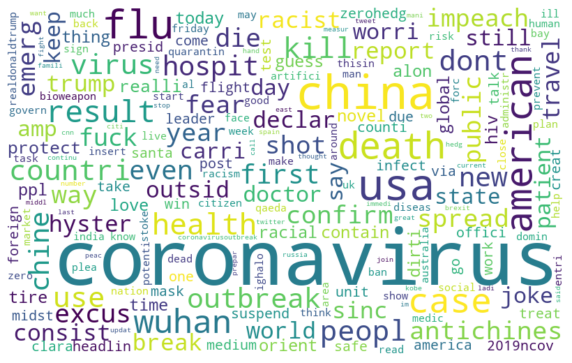

In [44]:
wordcloud(all_words_string)

It seems overwhelmingly negative with words such as kill, death, shot, outbreak, fear, antichinese, etc. which would mirror the sentiment distribution.

### Frequency Distribution


NLTK's frequency distribution takes tokens of an entire corpus and shows the number of times each word is used. For this project, I will use all tokens from all tweets as the corpus in which to calculate the frequency distribution.

In [45]:
freqdist = FreqDist(all_words_list)

# Top 20 words in corpus
freqdist.most_common(20)

[('coronavirus', 6923),
 ('#coronavirus', 1937),
 ('china', 1739),
 ('usa', 1616),
 ('flu', 1366),
 ('american', 1205),
 ('death', 1181),
 ('case', 1101),
 ('get', 879),
 ('wuhan', 846),
 ('result', 838),
 ('health', 773),
 ('kill', 749),
 ('use', 737),
 ('countri', 730),
 ('dont', 725),
 ('peopl', 725),
 ('virus', 670),
 ('outbreak', 668),
 ('hospit', 627)]

Below, we'll identify the top 50 words and calculate the percentage of the corpus each word holds.

In [46]:
# Total word count
tweet_word_count = sum(freqdist.values())
top_50_words = freqdist.most_common(50)

print('Word\t\t\tPercentage of Corpus\n')
for word in top_50_words:
    norm_freq = word[1]/tweet_word_count
    print('{} \t\t\t {:.4}'.format(word[0], round(norm_freq*100,2)))

Word			Percentage of Corpus

coronavirus 			 5.02
#coronavirus 			 1.4
china 			 1.26
usa 			 1.17
flu 			 0.99
american 			 0.87
death 			 0.86
case 			 0.8
get 			 0.64
wuhan 			 0.61
result 			 0.61
health 			 0.56
kill 			 0.54
use 			 0.53
countri 			 0.53
dont 			 0.53
peopl 			 0.53
virus 			 0.49
outbreak 			 0.48
hospit 			 0.45
chine 			 0.44
first 			 0.43
even 			 0.43
die 			 0.41
excus 			 0.41
confirm 			 0.39
year 			 0.39
emerg 			 0.39
way 			 0.38
shot 			 0.38
antichines 			 0.37
fear 			 0.36
spread 			 0.36
public 			 0.34
impeach 			 0.33
fuck 			 0.33
travel 			 0.31
sinc 			 0.31
outsid 			 0.31
hyster 			 0.3
consist 			 0.3
racist 			 0.29
declar 			 0.29
report 			 0.29
trump 			 0.29
world 			 0.29
new 			 0.28
say 			 0.28
worri 			 0.27
patient 			 0.27


## Bigrams

Calculating bigrams will give us the most common word associations in the entire corpus. 

In [47]:
from nltk.collocations import *

# Instantiate bigram measures method
bigram_measures = BigramAssocMeasures()

# Find and then score associations by frequency
tweet_finder = BigramCollocationFinder.from_words(all_words_list)
tweet_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

# Fifty most common bigrams
tweet_scored[:50]

[(('flu', 'shot'), 0.0037629146275149536),
 (('dont', 'even'), 0.0036251586006887803),
 (('even', 'get'), 0.0036251586006887803),
 (('excus', 'antichines'), 0.0036251586006887803),
 (('outsid', 'china'), 0.003052383541779953),
 (('death', 'year'), 0.002979880369766177),
 (('hospit', 'death'), 0.002979880369766177),
 (('countri', 'outsid'), 0.0029653797353634223),
 (('usa', 'american'), 0.0029653797353634223),
 (('use', 'excus'), 0.0029653797353634223),
 (('american', 'dont'), 0.002950879100960667),
 (('american', 'hyster'), 0.002950879100960667),
 (('china', 'american'), 0.002950879100960667),
 (('consist', 'coronavirus'), 0.002950879100960667),
 (('coronavirus', 'result'), 0.002950879100960667),
 (('death', 'countri'), 0.002950879100960667),
 (('flu', 'result'), 0.002950879100960667),
 (('fuck', 'flu'), 0.002950879100960667),
 (('get', 'fuck'), 0.002950879100960667),
 (('hyster', 'use'), 0.002950879100960667),
 (('result', 'death'), 0.002950879100960667),
 (('result', 'hospit'), 0.002

# Vectorization Strategies

In [91]:
tweet_list = df['full_text'].tolist()
labels_list = df['polarity'].tolist()

X_train, X_test, y_train, y_test = train_test_split(tweet_list, labels_list, test_size=.1, random_state=1)

In [115]:
def cv(data, vectorizer):
    
    embedding = vectorizer.fit_transform(data)
    
    return embedding, vectorizer


In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = {'pos':'red', 'neg':'blue', 'neu':'yellow'}

        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=pd.Series(test_labels).apply(lambda x: colors[x]))
            red_patch = mpatches.Patch(color='red', label='Positive')
            blue_patch = mpatches.Patch(color='blue', label='Negative')
            yellow_patch = mpatches.Patch(color='yellow', label='Neutral')
            plt.legend(handles=[red_patch, blue_patch,yellow_patch], prop={'size': 15})

## Tfidf Vectorization

Explain

In [63]:
tfidf_unigram = TfidfVectorizer(stop_words='english')
tfidf_bigram = TfidfVectorizer(stop_words='english', tokenizer=None, ngram_range=(1,2))
tfidf_trigram = TfidfVectorizer(stop_words='english', tokenizer=None, ngram_range=(1,3))

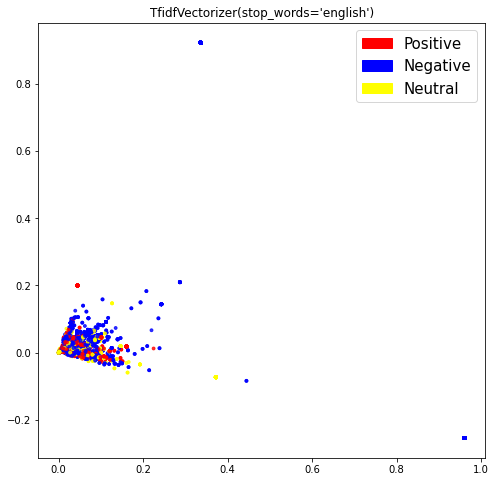

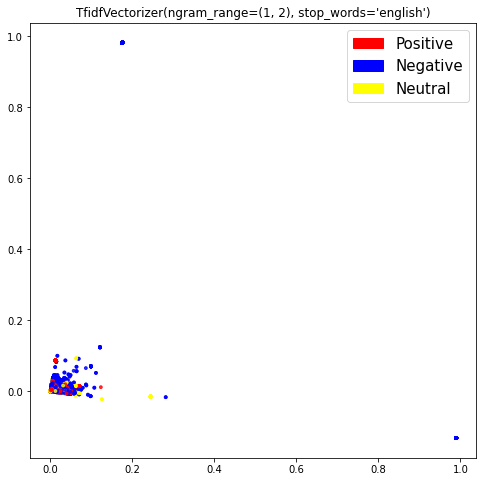

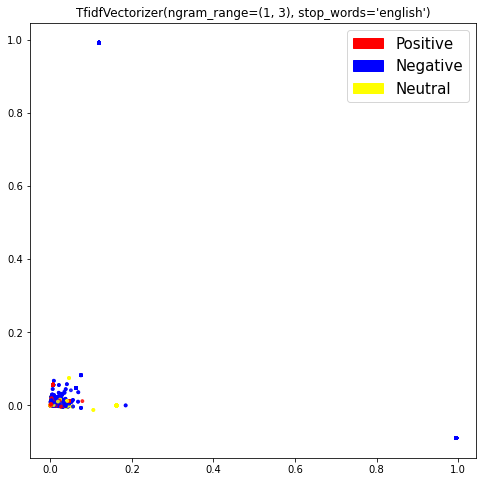

In [118]:
for vectorizer in [tfidf_unigram, tfidf_bigram, tfidf_trigram]:
    X_train_counts, count_vectorizer = cv(X_train, vectorizer)
    X_test_counts = count_vectorizer.transform(X_test)
    
    fig = plt.figure(figsize=(8, 8))
    plt.title(vectorizer)
    plot_LSA(X_train_counts, y_train)
    plt.show()

## Count Vectorization

Explain

In [65]:
count_unigram = CountVectorizer(stop_words='english')
count_bigram = CountVectorizer(stop_words='english', ngram_range=(1,2))
count_trigram = CountVectorizer(stop_words='english', ngram_range=(1,3))

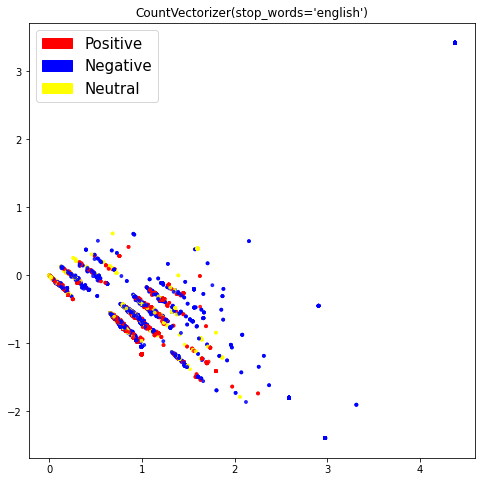

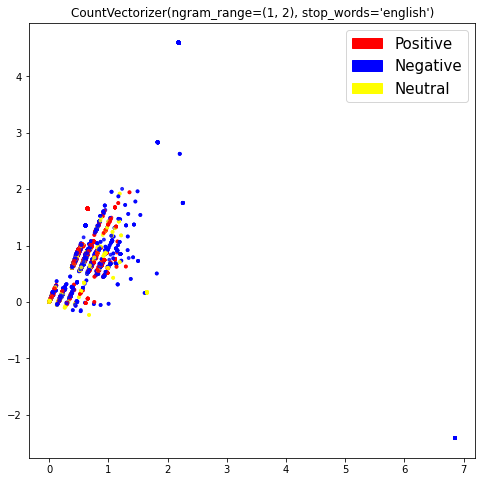

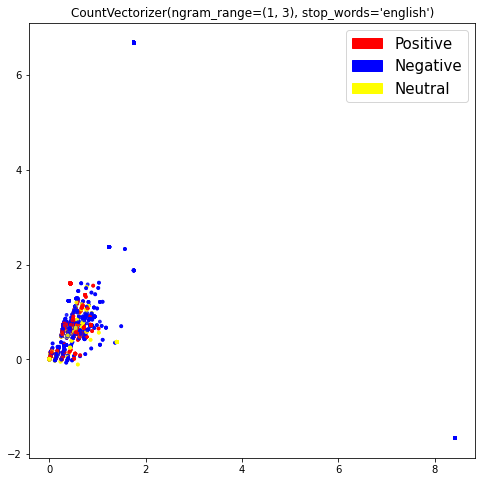

In [119]:
for vectorizer in [count_unigram, count_bigram, count_trigram]:
    X_train_counts, count_vectorizer = cv(X_train, vectorizer)
    X_test_counts = count_vectorizer.transform(X_test)
    
    fig = plt.figure(figsize=(8, 8))
    plt.title(vectorizer)
    plot_LSA(X_train_counts, y_train)
    plt.show()

## Word2Vec

Explain

## GLoVe

Explain

# Classification Algorithms and Validation Metrics

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
def classification(X_train, y_train):
    # Logistic Regression
    lr = LogisticRegression()
    lr_model = lr.fit(X_train, y_train)
    # Multinomail Naive Bayes
    nb = MultinomialNB()
    nb_model = nb.fit(X_train, y_train)
    # Random Forest
    rf = RandomForest()
    rf_model = rf.fit(X_train, y_train)
    # Decision Trees
    dt = DecisionTreeClassifier(criterion='entropy')
    dt_model = dt.fit(X_train, y_train)
    # XGBoost
    xgb = xgb.XGBClassifier()
    xgb_model = xgb.fit(X_train, y_train)
    # Support Vector Machines
    svm = SVC(kernel='linear')
    svm_model = svm.fit(X_train, y_train)
    
    return [lr_model, nb_model, rf_model, dt_model, xgb_model, svm_model]

In [ ]:
def model_validation(vectorizer, X_train, X_test, y_test):
    accuracy_scores = {}
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    classifiers = classification(X_train, X_test)
    for classifier in classifiers:
        preds = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        accuracy_scores[classifier] = accuracy
        
        
        
    accuracy_df = pd.from_dict(accuracy_scores, columns = ['Model', 'Accuracy'])
    return accuracy_df

# Hyperparameter Tuning